In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

import scipy.signal as si

import pysm3
import pysm3.units as usm

import skytools

import astropy.units as u 
import astropy as astro

from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

In [2]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [3]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  191.898 GB
     percent :   61.900 % 
        used :  265.445 GB
        free :  184.952 GB
      active :    9.900 GB
    inactive :  229.789 GB
     buffers :   15.941 MB
      cached :   52.725 GB
      shared :   16.395 GB
        slab :   27.568 GB



In [4]:
def modulo_180(x):
    if x>180:
        return (x-360)
    else:
        return x

In [5]:
def modulo_360(x):
    if x<0:
        return (x+360)
    else:
        return x

0. Read Planck map

In [6]:
NSIDE = 512
lmax = 2*NSIDE

In [7]:
resol = hp.nside2resol(nside=NSIDE)
amin2rad = np.pi/(60*180)

resol_amin = resol*amin2rad

print(resol)

0.0019986849764579854


Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [8]:
from toast.qarray import to_iso_angles, rotation, mult, to_lonlat_angles


In [98]:
#xrot = rotation([0,1,0], np.pi/2)

zrot = rotation([1,0,0], np.pi/2)


In [9]:
from toast.instrument_sim import fake_hexagon_focalplane, plot_focalplane

In [10]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

In [11]:
iso_angles = np.array([np.degrees(to_iso_angles(mult(xrot,focalplane[detec]["quat"]))) for detec in focalplane.detectors])


In [12]:
#iso_angles

array([[  88.08882932,    1.94993571,   22.5       ],
       [  88.08882932,    1.94993571,  112.5       ],
       [  90.        ,    3.05321419,   67.5       ],
       [  90.        ,    3.05321419,  157.5       ],
       [  90.        ,    0.84665724,   67.5       ],
       [  90.        ,    0.84665724,  157.5       ],
       [  91.91117068,    1.94993571,   22.5       ],
       [  91.91117068,    1.94993571,  112.5       ],
       [  88.89786687,    7.17209843,  -97.5670297 ],
       [  88.89786687,    7.17209843,   -7.5670297 ],
       [  88.89628048,    4.96503074,  -52.50613882],
       [  88.89628048,    4.96503074,   37.49386118],
       [  86.9857875 ,    6.06983805,  -52.54583908],
       [  86.9857875 ,    6.06983805,   37.45416092],
       [  86.98572831,    3.86012121,  -97.44803143],
       [  86.98572831,    3.86012121,   -7.44803143],
       [  93.01427169,    3.86012121,  142.44803143],
       [  93.01427169,    3.86012121, -127.55196857],
       [  91.10371952,    4.

In [13]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0}

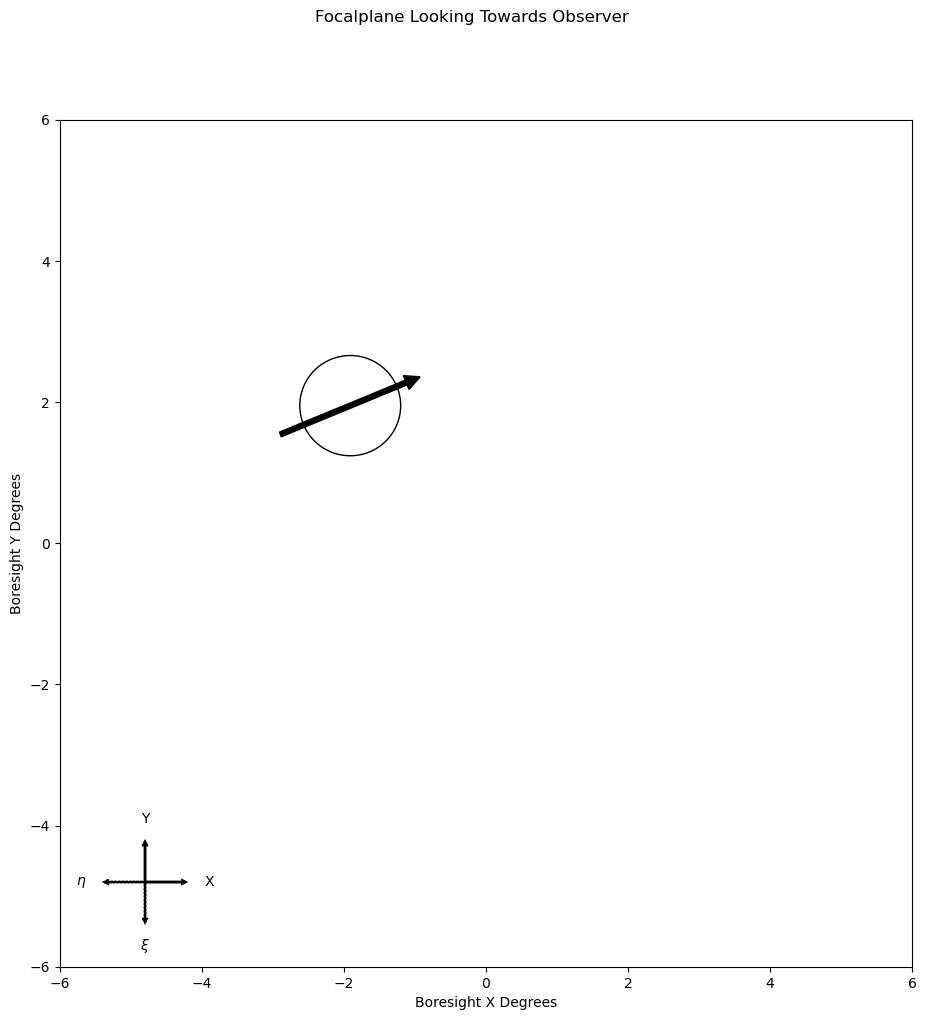

<Figure size 640x480 with 0 Axes>

In [14]:
plot_focalplane(focalplane, width=10*u.degree, height = 10*u.degree)
plt.savefig('two_detectors.png')

Print schedule information

In [15]:
schedule = toast.schedule.GroundSchedule()
schedule.read("POLE_DEEP_169-DEC0.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP_169-DEC0.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP_169-DEC0.txt totaling 84.0 minutes.


In [16]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2000-01-01T12:00:00+00:00 with El = 54.52 deg, Az 118.39 deg -- 189.2 deg>
>

Print telescope information

In [17]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_000_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [18]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [19]:
data = toast.Data(comm=toast_comm)

In [20]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [21]:
sim_ground.apply(data)

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [22]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
pointing.apply(data)

2. Noise simulation

In [23]:
ob = data.obs[0]

In [24]:
#weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "I")
#pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

In [25]:
#scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='cmb_030_GC_nside_I.FITS',pixel_pointing = pixels, stokes_weights = weights)
#scan_map.save_pointing = True#
#scan_map.apply(data)

In [38]:
quats = ob.detdata['quats'][0]

In [39]:
quats.shape

(50400, 4)

In [47]:
quats_1 = ob.detdata['quats'][0]

In [66]:
boresight_radec = ob.shared['boresight_radec']
boresight_azel = ob.shared['boresight_azel']

In [65]:
ob.shared

<SharedDataManager
    times (column): shape=(50400,), dtype=float64
    position (column): shape=(50400, 3), dtype=float64
    velocity (column): shape=(50400, 3), dtype=float64
    azimuth (column): shape=(50400,), dtype=float64
    elevation (column): shape=(50400,), dtype=float64
    boresight_azel (column): shape=(50400, 4), dtype=float64
    boresight_radec (column): shape=(50400, 4), dtype=float64
    flags (column): shape=(50400,), dtype=uint8>

In [89]:
time = ob.shared['times']

In [60]:
#iso_radec = np.degrees(to_iso_angles(mult(xrot,boresight_radec)))
iso_radec = np.degrees(to_iso_angles(mult(xrot,boresight_radec)))

In [99]:
iso_azel = np.degrees(to_lonlat_angles(mult(zrot,boresight_azel)))

In [85]:
iso_angpix1 = np.degrees(to_lonlat_angles(quats_1))


In [86]:
phi1,th1,psi1 = iso_angpix1


In [87]:
iso_angpix1

array([[  -9.32666841,   -9.1539472 ,   -8.9812259 , ...,   72.05957355,
          71.88766857,   71.7157634 ],
       [ -56.38544144,  -56.38546106,  -56.38548065, ...,  -56.38978345,
         -56.38977937,  -56.38977523],
       [-160.38045818, -160.38044145, -160.38042462, ..., -160.37108666,
        -160.37112696, -160.37116724]])

In [100]:
iso_azel

array([[-108.72149833, -108.81826723, -108.91476686, ..., -125.4731472 ,
        -125.47119266, -125.46899317],
       [ -30.70464938,  -30.64921208,  -30.59349974, ...,   -0.74808422,
          -0.848065  ,   -0.94804081],
       [ -33.57269242,  -33.76236207,  -33.95181381, ...,  -88.9503315 ,
         -88.81000598,  -88.66967304]])

In [79]:
np.where(np.abs(iso_azel[2,:])<1e-6)

(array([    0,     1,     2, ..., 50397, 50398, 50399]),)

In [84]:
np.where(np.abs(iso_azel[2,:])>1e-7)

(array([], dtype=int64),)

In [74]:
print(diff_el)

[-7.10542736e-15 -7.10542736e-15 -7.10542736e-15 ... -1.42108547e-14
 -7.10542736e-15 -7.10542736e-15]


In [75]:
np.std(diff_el)

2.9592235990475098e-15

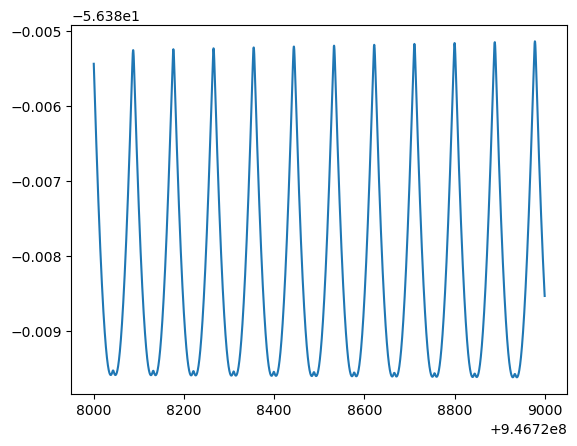

In [102]:
plt.plot(time[:10000],iso_angpix1[1][:10000])
plt.show()

In [103]:
peak1 = np.max(iso_angpix1[1][:1000])

In [109]:
xpeak1 = np.where(iso_angpix1[1][:1000]==peak1)[0][0]

In [104]:
peak1

-56.38525941360926

In [110]:
xpeak1

874

In [111]:
peakf = np.max(iso_angpix1[1])

In [112]:
xpeakf = np.where(iso_angpix1[1]==peakf)[0][0]

In [113]:
print(peakf,xpeakf)

-56.38469006768078 49873


In [115]:
drift = (peakf-peak1)/(time[xpeakf]-time[xpeak1])

In [118]:
drift*3600*365.25*24

3.6668485219649183

In [119]:
360/3.6668485219649183

98.17694890954762